In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
dataset = pd.read_csv(
    '../datasets/recursos-humanos-cyt.csv')

In [3]:
dataset.sample(n=5, replace=True)

,persona_id,provincia_id,provincia,max_nivel_educativo_desc,genero,edad_desc,tipo_personal,gran_area_formacion,tipo_organizacion_desc,categoria_CONICET,categoria_incentivos_id
7099,8992,6.0,Buenos Aires,Grado,femenino,30-39,docente,NaN,Universidad o instituto universitario estatal,No pertenece a Conicet,NaN
50597,71796,66.0,Salta,Especialización,femenino,60 y más,otro personal de la institucion,ciencias sociales,Universidad o instituto universitario estatal,No pertenece a Conicet,3.0
43971,57160,82.0,Santa Fe,Maestría,femenino,40-49,investigador,ciencias sociales,Universidad o instituto universitario estatal,No pertenece a Conicet,NaN
7063,8951,82.0,Santa Fe,Grado,femenino,50-59,otro personal de la institucion,humanidades,Organismo gubernamental de ciencia y tecnología,Personal de apoyo,NaN
23880,32059,30.0,Entre Ríos,Especialización,femenino,50-59,investigador,ciencias sociales,Universidad o instituto universitario estatal,No pertenece a Conicet,5.0


# Un poco de limpieza...

Vamos a remover los campos identificadores, dado que son útiles solo en caso de cruzar con otras tablas


In [4]:
cl_dataset = dataset.drop(columns=['persona_id', 'provincia_id', 'categoria_incentivos_id'])
cl_dataset.sample(n=5, replace=True)

,provincia,max_nivel_educativo_desc,genero,edad_desc,tipo_personal,gran_area_formacion,tipo_organizacion_desc,categoria_CONICET
380,Santiago Del Estero,Grado,femenino,30-39,docente,ciencias sociales,Universidad o instituto universitario privado,No pertenece a Conicet
432,Neuquén,Grado,femenino,30-39,becario de i+d,sin datos,OCT-Universidad,No pertenece a Conicet
31916,Buenos Aires,Maestría,femenino,40-49,investigador,ciencias sociales,Universidad o instituto universitario estatal,No pertenece a Conicet
39422,Buenos Aires,Grado,masculino,40-49,docente,ingenierías y tecnologías,Universidad o instituto universitario estatal,No pertenece a Conicet
53767,Corrientes,Grado,masculino,Menor de 30,docente,ciencias naturales y exactas,Universidad o instituto universitario estatal,No pertenece a Conicet


Existen categorías que representan valores nulos, así que rápidamente vamos a etiquetar correctamente dichos datos usando _np.nan_.

Existen también _trailing spaces_. Vamos a eliminar entonces este ruido

In [5]:
cl_dataset = cl_dataset.replace("Sin Provincia", np.nan)
cl_dataset = cl_dataset.replace("(?i)sin datos", np.nan, regex=True)
for col in cl_dataset.columns:
    cl_dataset[col] = cl_dataset[col].str.strip()

# Descripción General

No contamos con ninguna variable numérica en bruto. Sin embargo contamos con un campo de edad separado en contenedores, y también con algunas variables que tal vez puedan ser consideradas como ordinales, como ser por ejemplo el máximo nivel educativo alcanzado.

Vamos a emplear la función _**describe**_ de la librería pandas para que nos describa de forma general el dataset. Se suma además un gráfico de la cantidad de valores nulos y su distribución sobre las variables consideradas para los mismos fines.

In [6]:
cl_dataset.describe()

,provincia,max_nivel_educativo_desc,genero,edad_desc,tipo_personal,gran_area_formacion,tipo_organizacion_desc,categoria_CONICET
count,54165,56074,56233,56233,56233,48252,54617,56233
unique,51,8,2,5,4,6,11,12
top,Buenos Aires,Grado,femenino,30-39,investigador,ciencias sociales,Universidad o instituto universitario estatal,No pertenece a Conicet
freq,15025,20043,32877,17602,28936,13979,39964,39426


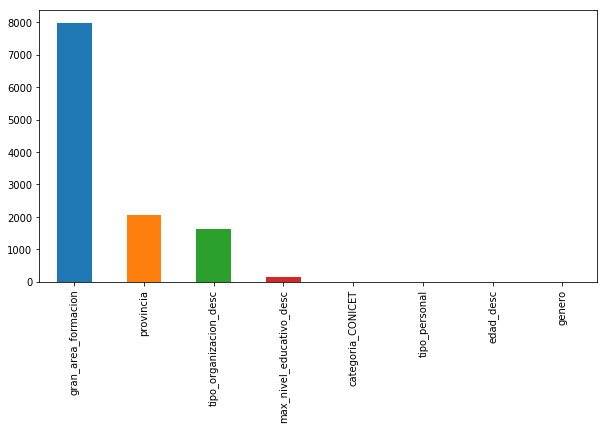

In [7]:
_ = cl_dataset.isnull().sum().sort_values(ascending=False).plot(kind='bar', figsize = (10,5))

Se pueden hacer las siguientes observaciones:
* Los valores nulos rondan el 14% en la categoría con más ocurrencias nulas, por lo que no será un factor perjudicial.
* Considerando los valores únicos por columna, se pueden ver valores acertados, exceptuando a provincia: en nuestro dataset hay 53 provincias distintas! Veamos y adaptemos esos datos.

In [8]:
cl_dataset.provincia.value_counts()

Buenos Aires           15025
CABA                   11021
Córdoba                 5978
Santa Fe                4592
Tucumán                 2220
Mendoza                 2212
Río Negro               1345
San Luis                1341
Entre Ríos              1152
Corrientes              1042
San Juan                1041
Salta                    937
Misiones                 930
Chubut                   765
Catamarca                645
La Pampa                 591
Chaco                    581
Jujuy                    579
Neuquén                  534
La Rioja                 446
Santiago Del Estero      369
Santa Cruz               342
Formosa                  238
Tierra Del Fuego         191
Lima                       7
California                 4
Florida                    4
Paris                      3
Minnesota                  3
Pernambuco                 3
Nebraska                   2
New York                   2
Colombia                   2
Rio De Janeiro             1
Connecticut   

Existen un problema grande y es que:
* Se cuentan como provincias ciudades extranjeras, siendo ademas que la gran mayoría de ellas cuentan con una ocurrencia.

Mientras que otro punto discutible es:
* CABA y Buenos Aires disociadas. Sin embargo esta distinción es entendible en el sentido que Buenos Aires seguramente hace referencia al Gran Buenos Aires, excluyendo a Capital Federal; mientras que CABA hace referencia a Capital Federal.

Consideramos necesario entonces hacer una categoría "Extranjero".

In [9]:
pcias_arg = ['CABA', 'Entre Ríos', 'San Luis', 'Córdoba', 'Buenos Aires', 'Corrientes', 'Tucumán', 'Santa Fe', 'Chubut', 'Formosa', 'Catamarca', 'Misiones', 'Salta', 'Mendoza', 'Chaco', 'Río Negro', 'Santiago Del Estero', 'San Juan', 'Jujuy', 'Neuquén', 'La Rioja', 'Santa Cruz', 'La Pampa', 'Tierra Del Fuego']
def pcia_replacm(pcia):
    if not (pcia in pcias_arg):
        return 'Extranjero'
    return pcia
cl_dataset.provincia = cl_dataset.provincia.map(pcia_replacm, na_action='ignore')
cl_dataset.provincia.value_counts()

Buenos Aires           15025
CABA                   11021
Córdoba                 5978
Santa Fe                4592
Tucumán                 2220
Mendoza                 2212
Río Negro               1345
San Luis                1341
Entre Ríos              1152
Corrientes              1042
San Juan                1041
Salta                    937
Misiones                 930
Chubut                   765
Catamarca                645
La Pampa                 591
Chaco                    581
Jujuy                    579
Neuquén                  534
La Rioja                 446
Santiago Del Estero      369
Santa Cruz               342
Formosa                  238
Tierra Del Fuego         191
Extranjero                48
Name: provincia, dtype: int64

In [10]:
# def simple_barplot():
#     ax = seaborn.barplot(data=fdps.to_frame().reset_index(),
#         x='index', y='area', color='#2ecc71')
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
#     seaborn.despine()
#dataset['provincia'].value_counts()

In [11]:
# fig, axs = plt.subplots(ncols=3, figsize=(10,10))
# sns.barplot(data=dataset.provincia.value_counts().to_frame().reset_index(),
#         x='index', y='provincia', color='#2ecc71', ax=axs[0], rotation=).set_xticklabels(
#             ax.get_xticklabels(), rotation=40, ha="right")
# sns.barplot(data=dataset.max_nivel_educativo_desc.value_counts().to_frame().reset_index(),
#         x='index', y='max_nivel_educativo_desc', color='#2ecc71', ax=axs[1])

In [12]:
#dataset[['max_nivel_educativo_desc']]
#sns.pairplot(dataset)
#fig, axs = plt.subplots(3, 3)
#sns.barplot(data=dataset.provincia.value_counts().to_frame().reset_index(),
#        x='index', y='provincia', color='#2ecc71')
# sns.pairplot?